In [ ]:
# Using Transfer Learning with Pretrained Model Resnet18

In [7]:
#  1. Imports and Configuration
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Config
DATA_DIR = r"C:\Users\HP\Desktop\Brain_tumor_prediction\brainMRI_data"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
VAL_DIR = os.path.join(DATA_DIR, "Validation")
TEST_DIR = os.path.join(DATA_DIR, "Testing")

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-3
NUM_CLASSES = 4
MODEL_PATH = "resnet_transfer.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
#  2. Data Transforms and Loaders (with Augmentation + ImageNet Normalization)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset   = datasets.ImageFolder(VAL_DIR, transform=val_test_transform)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [9]:
from torchvision import models
import torch.nn as nn

# Load pretrained model
resnet = models.resnet18(pretrained=True)

# Freeze all layers first
for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze only layer4
for name, param in resnet.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

# Replace the classifier head (FC block)
in_features = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, NUM_CLASSES)
).to(device)

model = resnet.to(device)


c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
#  4. Train Function with Validation Accuracy + Time
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

def train_model(model, train_loader, val_loader):
    # optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    criterion = nn.CrossEntropyLoss()
    best_acc = 0

    for epoch in range(EPOCHS):
        start = time.time()
        model.train()
        total_loss = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_acc = evaluate(model, val_loader)
        end = time.time()

        print(f" Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.3f} | Val Acc: {val_acc:.2f}% | Time: {end-start:.1f}s")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), MODEL_PATH)
            print(" Best model saved!")
            # Train the Model
            
train_model(model, train_loader, val_loader)


Epoch 1/10: 100%|██████████| 286/286 [03:03<00:00,  1.55it/s]


 Epoch 1/10 | Loss: 127.481 | Val Acc: 93.16% | Time: 217.6s
 Best model saved!


Epoch 2/10: 100%|██████████| 286/286 [03:07<00:00,  1.52it/s]


 Epoch 2/10 | Loss: 58.449 | Val Acc: 96.14% | Time: 220.1s
 Best model saved!


Epoch 3/10: 100%|██████████| 286/286 [03:12<00:00,  1.49it/s]


 Epoch 3/10 | Loss: 41.983 | Val Acc: 96.49% | Time: 226.7s
 Best model saved!


Epoch 4/10: 100%|██████████| 286/286 [03:23<00:00,  1.41it/s]


 Epoch 4/10 | Loss: 30.918 | Val Acc: 96.49% | Time: 239.0s


Epoch 5/10: 100%|██████████| 286/286 [03:32<00:00,  1.35it/s]


 Epoch 5/10 | Loss: 26.680 | Val Acc: 97.63% | Time: 249.2s
 Best model saved!


Epoch 6/10: 100%|██████████| 286/286 [15:17<00:00,  3.21s/it]    


 Epoch 6/10 | Loss: 20.020 | Val Acc: 97.28% | Time: 950.2s


Epoch 7/10: 100%|██████████| 286/286 [03:07<00:00,  1.53it/s]


 Epoch 7/10 | Loss: 12.763 | Val Acc: 96.67% | Time: 219.7s


Epoch 8/10: 100%|██████████| 286/286 [03:10<00:00,  1.50it/s]


 Epoch 8/10 | Loss: 14.054 | Val Acc: 98.25% | Time: 225.1s
 Best model saved!


Epoch 9/10: 100%|██████████| 286/286 [03:27<00:00,  1.38it/s]


 Epoch 9/10 | Loss: 22.505 | Val Acc: 97.11% | Time: 244.7s


Epoch 10/10: 100%|██████████| 286/286 [03:28<00:00,  1.37it/s]


 Epoch 10/10 | Loss: 8.766 | Val Acc: 97.63% | Time: 247.7s



 Test Accuracy: 98.63%

 Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.96      0.98      0.97       306
     notumor       1.00      0.99      0.99       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



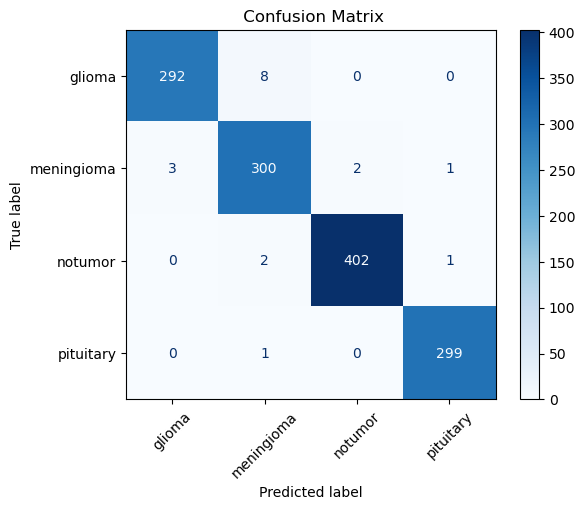

In [11]:
# 5. Load Best Model and Test Evaluation
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
model.eval()

# Get predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Accuracy
test_acc = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\n Test Accuracy: {test_acc:.2f}%")

# Classification Report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(" Confusion Matrix")
plt.show()
